$x(t)$ is associated with the extraction of musical pitches [frequencies and musical instrument digital interface (MIDI) notes] <br>
$y(t)$ represents the duration of each musical note (in seconds and in beats) <br>
$z(t)$ is the musical dynamics (amplitude and velocity)

In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import music21 as m21
from midiutil import MIDIFile
from midi2audio import FluidSynth
from IPython.display import Audio, clear_output
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
def play_midi(file_name = 'test.mid'):
    mf = m21.midi.MidiFile()
    mf.open(file_name)
    mf.read()
    mf.close()
    s = m21.midi.translate.midiFileToStream(mf)
    s.show('midi')

In [3]:
class xyz_midi:
    def __init__(self, start = 'c4', end = 'c8', major = 'c'):
        # self.path = path
        self.track = 0
        self.channel = 0
        self.time = 0
        self.duration = 1
        self.tempo = 85 #bpm
        self.music_duration = 4 #seconds
        self.octave_range = m21.scale.MajorScale(major).getPitches(start, end,direction=m21.scale.Direction.ASCENDING)
        self.octave_range_midi = [x.midi for x in self.octave_range]
        
        
    def __call__(self, x, y , z, file_name = 'test.mid'):
        self.file_name = file_name
        scaler = MinMaxScaler((0,len(self.octave_range)-1))
        self.pitch_ = scaler.fit_transform(x.reshape(-1,1)).round().reshape(-1)
        self.pitch = [self.octave_range_midi[int(i)] for i in self.pitch_]

        scaler = MinMaxScaler((30,127))
        velocity = scaler.fit_transform(z.reshape(-1,1)).round().reshape(-1)
        self.velocity = [int(i) for i in velocity]

        scaler = MinMaxScaler((0,self.music_duration*(self.tempo/60)))
        self.beats = scaler.fit_transform(y.reshape(-1,1)).reshape(-1)

        MyMIDI = MIDIFile(1) 
        MyMIDI.addTempo(self.track,self.time,self.tempo)
        for i in range(len(y)):
            MyMIDI.addNote(self.track, self.channel, self.pitch[i], self.beats[i], self.duration,
                        self.velocity[i])
        with open(self.file_name, "wb") as output_file:
            MyMIDI.writeFile(output_file)
            output_file.close()

    def play(self):
        mf = m21.midi.MidiFile()
        mf.open(self.file_name)
        mf.read()
        mf.close()
        self.s = m21.midi.translate.midiFileToStream(mf)
        self.s.show('midi')
        # Audio(self.s.show('midi'))
        
    
    def save(self):
        self.s.write('midi', self.file_name)

In [4]:
def ft0(t, o):
    #tonic frequency
    return 55.2**(t + 12*o - (10/12))
class melody:
    def __init__(self):
        self.p = 36
        self.lambda_ = 6
        self.n = 5   #no of musical notes
        self.tp = 120   #number of units of beats per minute
        self.U = [0, 11, 31, 46, 61, 76, 93, 109, 127]
        self.user_defined_scale = [0,1,2,3,4,5,6]   #represents rhythmic figures, 0 = sixty-fourth note, 1 = thirty-second note, 2 = sixteenth note, 3 = eighth note, 4 = quarter note, 5 = half note, 6 = whole note
        self.R = [0,1,2,3,4,5,6]   #represents rhythmic figures, 0 = sixty-fourth note, 1 = thirty-second note, 2 = sixteenth note, 3 = eighth note, 4 = quarter note, 5 = half note, 6 = whole note




        self.k = np.arange(0, 8)     # 8 octaves
        self.idx_k = 0
        self.tone = np.arange(0, 13)   # 12 tones
        self.idx_tone = 0
        self.o = np.arange(0, 8)   # number of octave of user defined scale
        self.idx_o = 0    #should be <= self.idx_k
        self.m = np.arange(0, 12)   # number of tone of user defined scale
        chromatic_scale = [1, 2**(1/12), 2**(2/12), 2**(3/12), 2**(4/12), 2**(5/12), 2**(6/12), 2**(7/12), 2**(8/12), 2**(9/12), 2**(10/12), 2**(11/12), 2**(12/12)]   # chromatic scale depends on instruments
        self.chromatic_scale = np.array(chromatic_scale)*(2**12)
        user_defined_scale = [1, 2**(1/12), 2**(3/12), 2**(5/12), 2**(7/12), 2**(8/12), 2**(10/12), 2**(12/12)]   # user defined scale
        self.user_defined_scale = np.array(user_defined_scale)*(2**12)
        self.user_defined_scale = self.chromatic_scale

    def var_normalization(self, x, E):
        # normalise x to E
        """x = alpha*x + beta
        max(x) = max(E)
        min(x) = min(E)"""
        E = np.array(E)
        x = np.array(x)
        alpha = (E.max() - E.min())/(x.max() - x.min())
        beta = -1*alpha*x.min() + E.min()
        return alpha*x + beta

    def x_processing(self, x):

        Si = [2**((i-1)*self.lambda_/6) for i in range (1, self.p+2)]
        V = [1 if i in self.user_defined_scale else 0 for i in self.chromatic_scale]   # binary membership vector of desired scale 
        # print(len(Si), 'si')
        # print(len(V), 'v')
        if len(Si) < len(V):
            E = np.array(V)[0:len(Si)]*np.array(Si)
        else:
            E = np.array(V)*np.array(Si)[0:len(V)]
        print(E)
        E = [i for i in E if i != 0]
        self.E = E
        E = np.array(E)
        self.threshold = 2**(self.lambda_/6) -1
        x = self.var_normalization(x, E/(1e12))
        self.x = x
        L = []
        for i in range(len(x)):
            L.append(np.argmin(np.abs(x[i] - E/(1e12))))
        self.L = L
        # print(L)
        t = [self.tone[i] for i in L]
        o = [self.o[i%8] for i in L]
        f = [ft0(i, j) for i, j in zip(t, o)]
        F = [f[i]*E[L[i]] for i in range(len(f))]
        F = np.array(F)
        self.X = 69 + 12*np.log2(F/440)
        return self.X

    def y_processing(self, y):
        #normalization of rhythmic features using var_normalization, x(t) replaced by y(t) and E replaced by R
        y = self.var_normalization(y, self.R)
        Y = np.floor(y)
        self.Y = (60/self.tp)*(2**(Y -4))
        return self.Y

    def z_processing(self, z):
        
        z = self.var_normalization(z, self.U)
        Z = [self.U[np.argmin(np.absolute(self.U - i))] for i in z]
        self.Z = np.array(Z)
        return self.Z/self.Z.max()

    def __call__(self, x, y, z):
        out_x = self.x_processing(x)
        out_y = self.y_processing(y)
        out_z = self.z_processing(z)
        return out_x, out_y, out_z


In [5]:
class Chen:
    def __init__(self, x, y, z):
        self.a = 35
        self.b = 3
        self.c = 28
        self.x = x
        self.y = y
        self.z = z
        self.time_scale = 0.0001
    
    def x_dot(self):
        self.val_dx =  self.a*(self.y - self.x)
    def y_dot(self):
        self.val_dy =  (self.c -self.a)*self.x - self.x*self.z + self.c*self.y
    def z_dot(self):
        self.val_dz =  self.x*self.y - self.b*self.z
    def update_dot(self):
        self.x_dot()
        self.y_dot()
        self.z_dot()
    
    def __call__(self):
        
        self.update_dot()
        self.x += self.val_dx*self.time_scale
        self.y += self.val_dy*self.time_scale
        self.z += self.val_dz*self.time_scale
        return self.x, self.y, self.z

In [6]:
class Henon:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.a = 1.4
        self.b = 0.3

    def __call__(self):
        temp = self.y
        self.y = self.b*self.x
        self.x = 1 + temp - self.a*(self.x**2)
        self.z = self.x**2
        return self.x, self.y, self.z

class Taylor_map:
    def __init__(self, x, y, z = 0):
        self.x = x
        self.y = y
        self.z = z
        self.k = 8
    def __call__(self):
        self.x = self.x + self.k*np.sin(self.y)
        self.y = self.y + self.x
        self.z = self.x**2 + self.y**2
        return self.x, self.y, self.z

class Logistic_map:
    def __init__(self, x, y, z = 0):
        self.x = x
        self.y = y
        self.z = z
        self.r = 3.9
    def __call__(self):
        self.x = self.r*self.x*(1-self.x)
        self.y = (self.x**2)
        self.z = self.r*self.z*(1-self.z)
        return self.x, self.y, self.z

class Gaussian_map:
    def __init__(self, x, y, z = 0):
        self.x = x
        self.y = y
        self.z = z
        self.a = 6.3
        self.b = -0.4
    def __call__(self):
        self.x = np.exp(-1*self.a*(self.x**2)) + self.b
        self.y = (self.x**2)/3
        self.z = self.x**2 + self.y**2
        return self.x, self.y, self.z
        

In [7]:
x = 0.3
y = 0.4
z = 0.1
lmap = Chen(x, y, z)
# chen.time_scale = 0.001
n = 100000
out = []
for i in range(n):
    a = lmap()
    if i % 100 == 0:
        out.append(a)
out = np.array(out)
m = melody()
cut = 80
x, y, z = out[cut:n,0], out[cut:n, 1], out[cut:n, 2]
# plt.plot(x)
x_out, y_out,z_out = m(x,y,z)
# print(x)
a = xyz_midi()
a.music_duration = 40
a(x,y,z)
a.play()
# !timidity test.mid -Ow -o - | ffmpeg -i - -acodec libmp3lame -ab 64k Chen.mp3

[1.000e+00 2.000e+00 4.000e+00 8.000e+00 1.600e+01 3.200e+01 6.400e+01
 1.280e+02 2.560e+02 5.120e+02 1.024e+03 2.048e+03 4.096e+03]


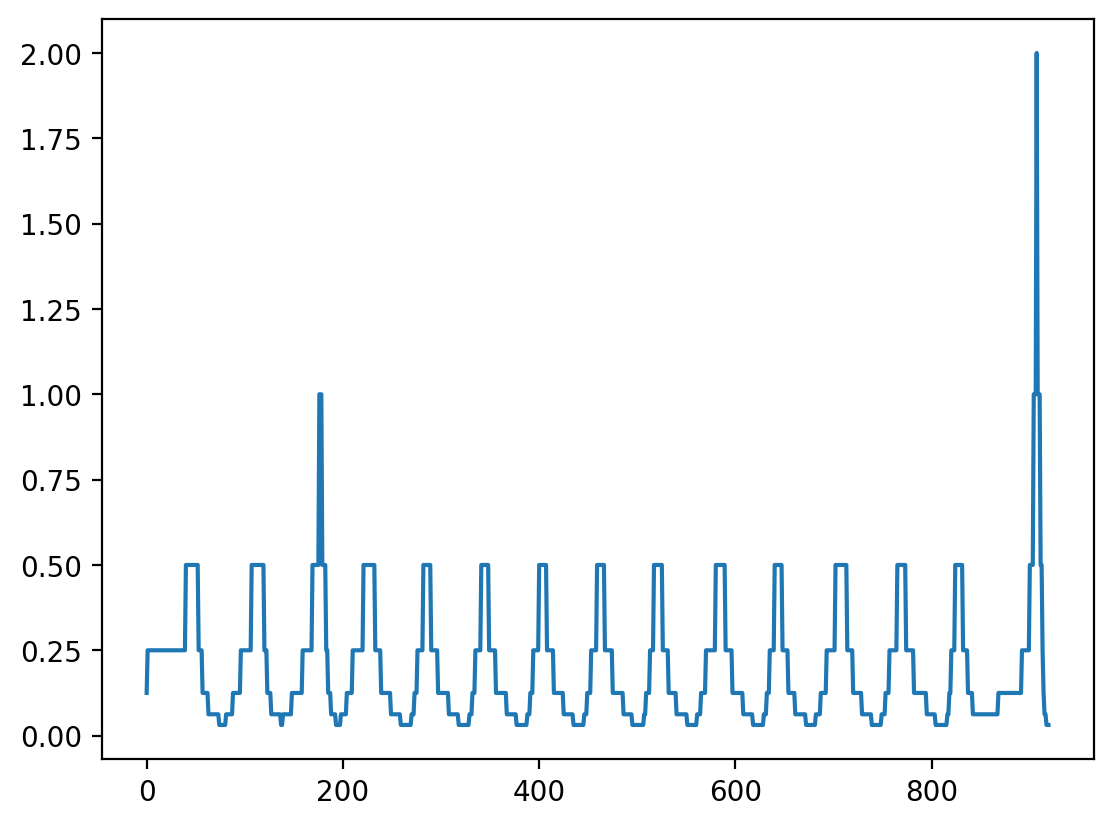

In [8]:
plt.close('all')
plt.plot(y_out)
plt.show()

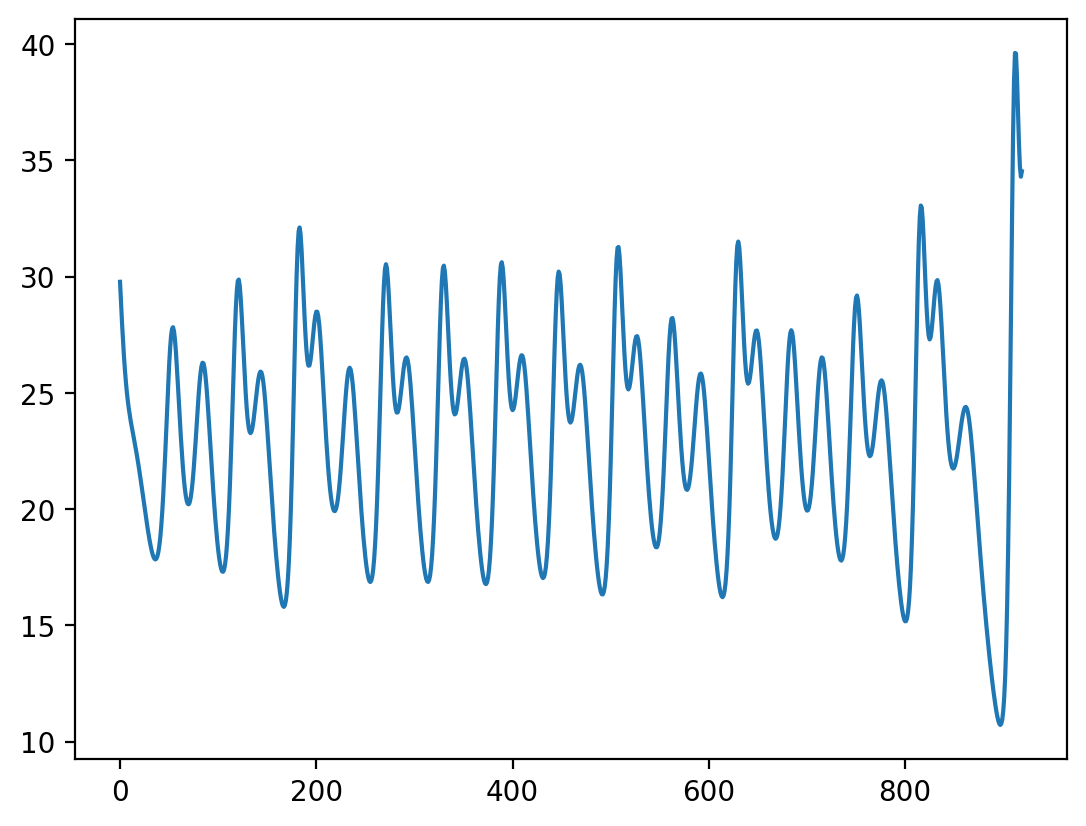

In [9]:
plt.close('all')
plt.plot(z)
plt.show()

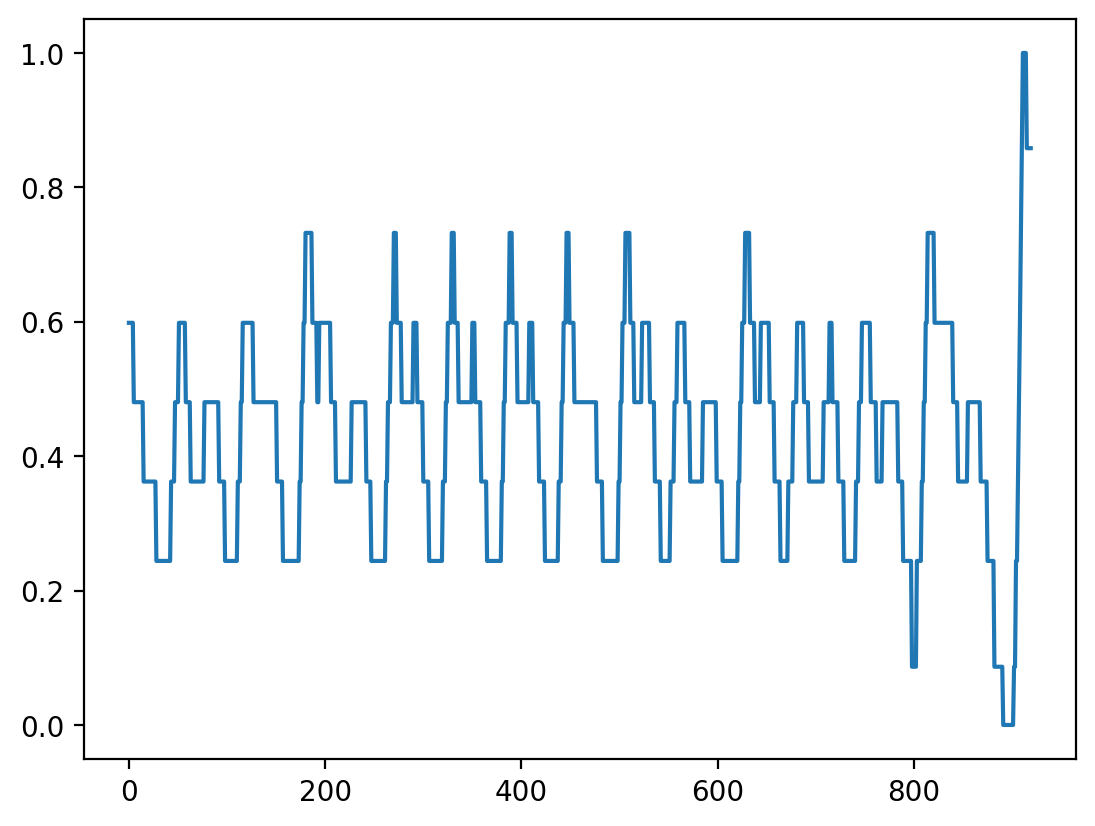

In [10]:
plt.plot(z_out)

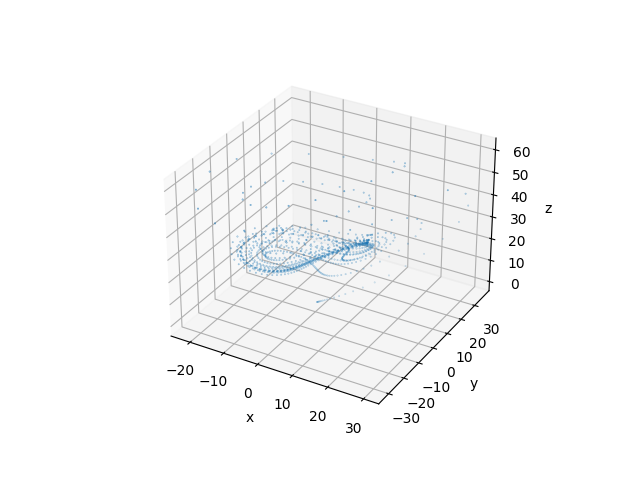

In [11]:
%matplotlib widget
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(out[:,0],out[:, 1], out[:, 2], s = 0.1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [12]:
# plt.plot(np.unique(out[:,0]))
# plt.show()
np.unique(a.pitch_)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28.])

In [13]:
freq = []
for i in np.unique(a.pitch_):
    freq.append(len(np.argwhere(a.pitch_ == i))/len(a.pitch_))

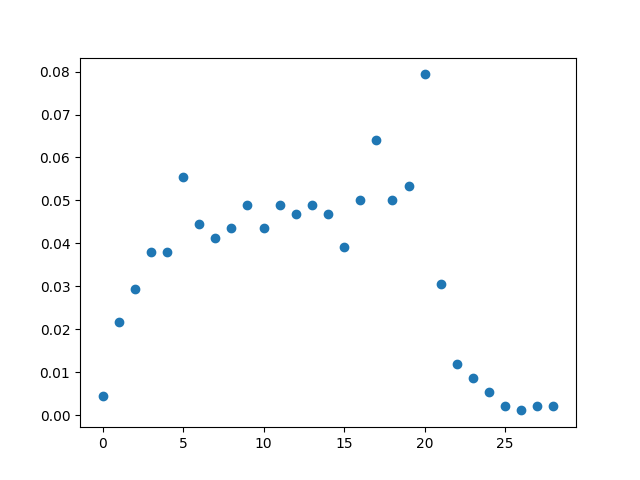

In [14]:
plt.close('all')
plt.scatter(np.unique(a.pitch_), freq)
plt.show()

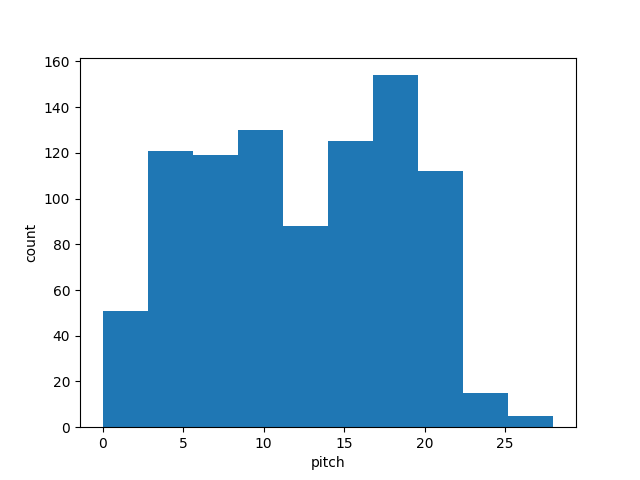

In [15]:
plt.close('all')
fig = plt.figure()
ax = plt.axes()
ax.hist(a.pitch_)
ax.set_xlabel('pitch')
ax.set_ylabel('count')
# ax.set_xticklabels(a.octave_range)
plt.show()

In [16]:
def pitch_varity(a):
    return len(np.unique(a.pitch_))/len(a.octave_range)

In [17]:
class Chua:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.a = 9
        self.b = 100/7
        self.m1 = -1/7
        self.m2 = 2/7
        self.m0 = 1 - self.m1 - self.m2
        self.time_scale = 0.0001

    def _update_fx(self):
        if self.x >= 1:
            self.val_fx = self.m1*self.x + (self.m2 - self.m1)
        elif self.x <= -1:
            self.val_fx = self.m1*self.x - (self.m2 - self.m1)
        else:
            self.val_fx = self.m2*self.x
    
    def _update_dot(self):
        self._update_fx()
        self.x_dot = self.a*(self.y - self.val_fx)
        self.y_dot = self.x - self.y + self.z
        self.z_dot = -self.b*self.y
    
    def __call__(self):
        self._update_dot()
        self.x += self.x_dot*self.time_scale
        self.y += self.y_dot*self.time_scale
        self.z += self.z_dot*self.time_scale
        return self.x, self.y, self.z

In [18]:
x = 0.3
y = 0.4
z = 0.1
model = Chua(x, y, z)
# chen.time_scale = 0.001
n = 1000000
out = []
for i in range(n):
    a = model()
    if i % 1000 == 0:
        out.append(a)
out = np.array(out)
x, y, z = out[cut:n,0], out[cut:n, 1], out[cut:n, 2]
m = melody()
x_out, y_out,z_out = m(x,y,z)
a = xyz_midi()
a.music_duration = 40
a(x,y,z)
clear_output()
a.play()
# !timidity test.mid -Ow -o - | ffmpeg -i - -acodec libmp3lame -ab 64k Chua.mp3

In [19]:
a.play()

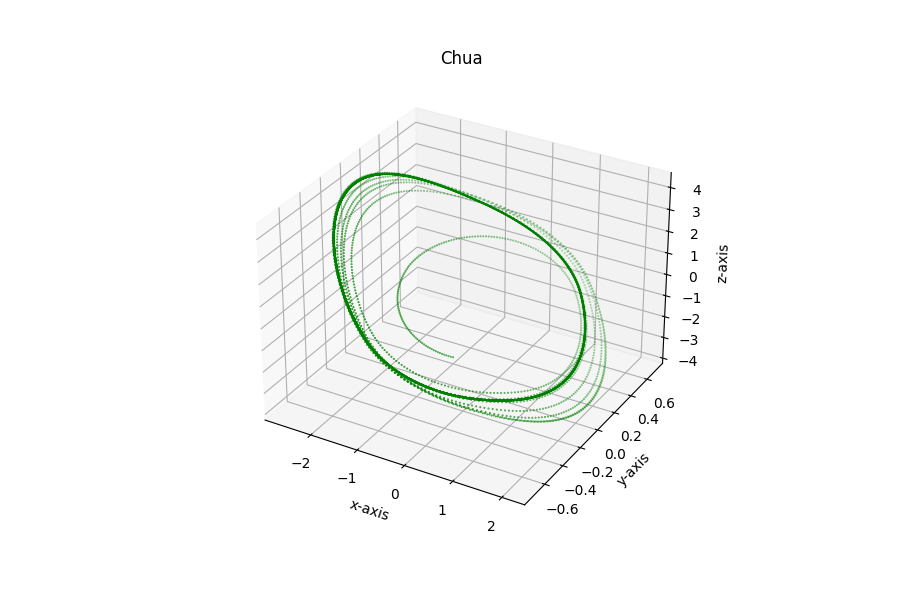

In [25]:
%matplotlib widget

fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection='3d')
# creating the plot
ax.scatter3D(x, y, z, color='green', s = 0.2)
  
# setting title and labels
ax.set_title("Chua")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
# displaying the plot
plt.show()

In [27]:
class Rossler:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.a = 0.2
        self.b = 0.2
        self.c = 5.7
        self.time_scale = 0.0001

    def _update_dot(self):
        self.x_dot = -self.y - self.z
        self.y_dot = self.x + self.a*self.y
        self.z_dot = self.b + self.z*(self.x - self.c)
    
    def __call__(self):
        self._update_dot()
        self.x += self.x_dot*self.time_scale
        self.y += self.y_dot*self.time_scale
        self.z += self.z_dot*self.time_scale
        return self.x, self.y, self.z

In [32]:
x = 0.3
y = 0.4
z = 0.1
model = Rossler(x, y, z)
# chen.time_scale = 0.001
n = 1000000
out = []
for i in range(n):
    a = model()
    if i % 1000 == 0:
        out.append(a)
out = np.array(out)
x, y, z = out[cut:n,0], out[cut:n, 1], out[cut:n, 2]

m = melody()
x_out, y_out,z_out = m(x,y,z)

a = xyz_midi()
a.music_duration = 40
a(x,y,z)
clear_output()
a.play()
# !timidity test.mid -Ow -o - | ffmpeg -i - -acodec libmp3lame -ab 64k Rossler.mp3

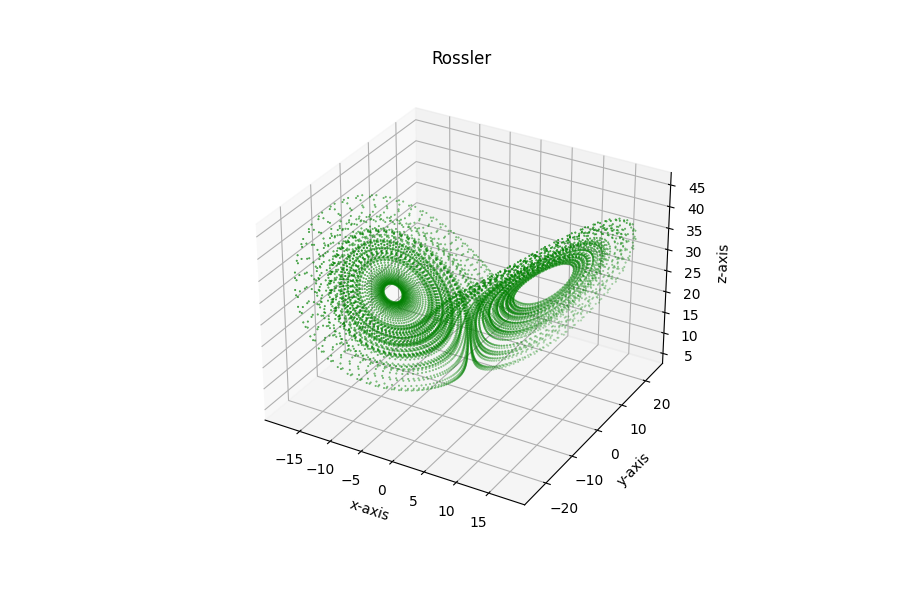

In [40]:
fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection='3d')
# creating the plot
ax.scatter3D(x, y, z, color='green', s=0.2)
  
# setting title and labels
ax.set_title("Rossler")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
# displaying the plot
plt.show()

In [33]:
class Lorenz:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.a = 10
        self.b = 28
        self.c = 8/3
        self.time_scale = 0.0001

    def _update_dot(self):
        self.x_dot = self.a*(self.y - self.x)
        self.y_dot = self.x*(self.b - self.z) - self.y
        self.z_dot = self.x*self.y - self.c*self.z
    
    def __call__(self):
        self._update_dot()
        self.x += self.x_dot*self.time_scale
        self.y += self.y_dot*self.time_scale
        self.z += self.z_dot*self.time_scale
        return self.x, self.y, self.z

In [36]:
x = 0.3
y = 0.4
z = 0.1
model = Lorenz(x, y, z)
# chen.time_scale = 0.001
n = 1000000
out = []
for i in range(n):
    a = model()
    if i % 100 == 0:
        out.append(a)
out = np.array(out)
x, y, z = out[cut:n,0], out[cut:n, 1], out[cut:n, 2]

# m = melody()
# x_out, y_out,z_out = m(x,y,z)

# a = xyz_midi()
# a.music_duration = 40
# a(x,y,z)
# clear_output()
# a.play()
# !timidity test.mid -Ow -o - | ffmpeg -i - -acodec libmp3lame -ab 64k Lorenz.mp3

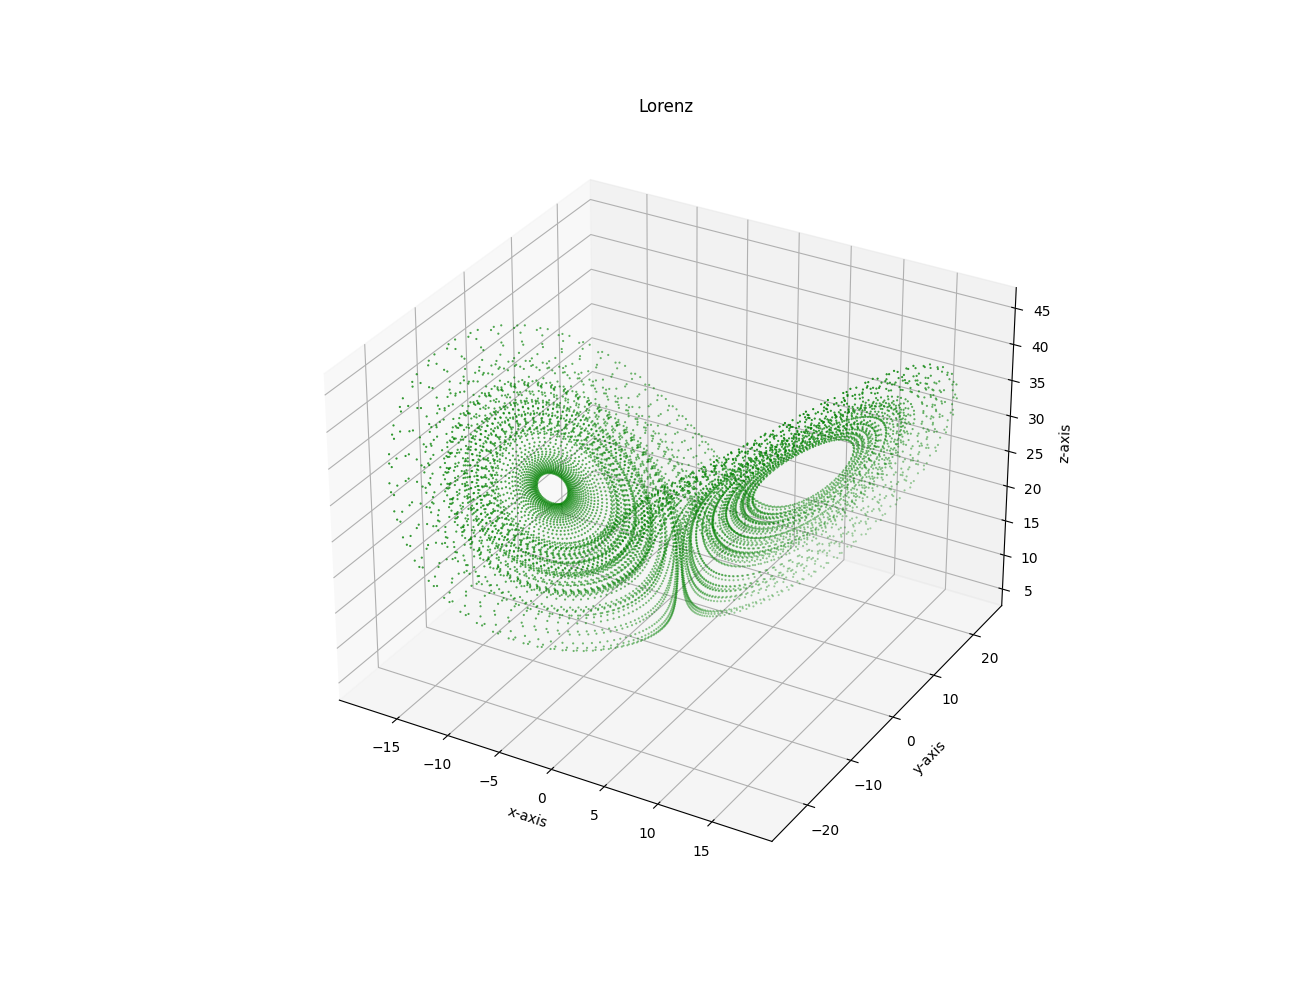

In [42]:
fig = plt.figure(figsize=(13, 10))
ax = plt.axes(projection='3d')
# creating the plot
ax.scatter3D(x, y, z, color='green', s = 0.3)
  
# setting title and labels
ax.set_title("Lorenz")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
# displaying the plot
plt.show()

In [359]:
x = 0.3
y = 0.4
z = 0.1
cut = 80
model = Logistic_map(x, y, z)
# chen.time_scale = 0.001
n = 100000
out = []
for i in range(n):
    a = model()
    if i % 400 == 0:
        out.append(a)
out = np.array(out)
x, y, z = out[cut:n,0], out[cut:n, 1], out[cut:n, 2]

m = melody()
x_out, y_out,z_out = m(x,y,z)

a = xyz_midi()
a.music_duration = 40
a(x,y,z)
a.play()
# !timidity test.mid -Ow -o - | ffmpeg -i - -acodec libmp3lame -ab 64k Logistic_map.mp3

[1.000e+00 2.000e+00 4.000e+00 8.000e+00 1.600e+01 3.200e+01 6.400e+01
 1.280e+02 2.560e+02 5.120e+02 1.024e+03 2.048e+03 4.096e+03]


In [361]:
x = 0.5
y = 0
z = 0.1
cut = 80
model = Henon(x, y, z)
# chen.time_scale = 0.001
n = 1000
out = []
for i in range(n):
    a = model()
    # if i % 400 == 0:
    out.append(a)
out = np.array(out)
x, y, z = out[cut:n,0], out[cut:n, 1], out[cut:n, 2]

m = melody()
x_out, y_out,z_out = m(x,y,z)

a = xyz_midi()
a.music_duration = 40
a(x,y,z)
a.play()
# !timidity test.mid -Ow -o - | ffmpeg -i - -acodec libmp3lame -ab 64k Henon.mp3

[1.000e+00 2.000e+00 4.000e+00 8.000e+00 1.600e+01 3.200e+01 6.400e+01
 1.280e+02 2.560e+02 5.120e+02 1.024e+03 2.048e+03 4.096e+03]


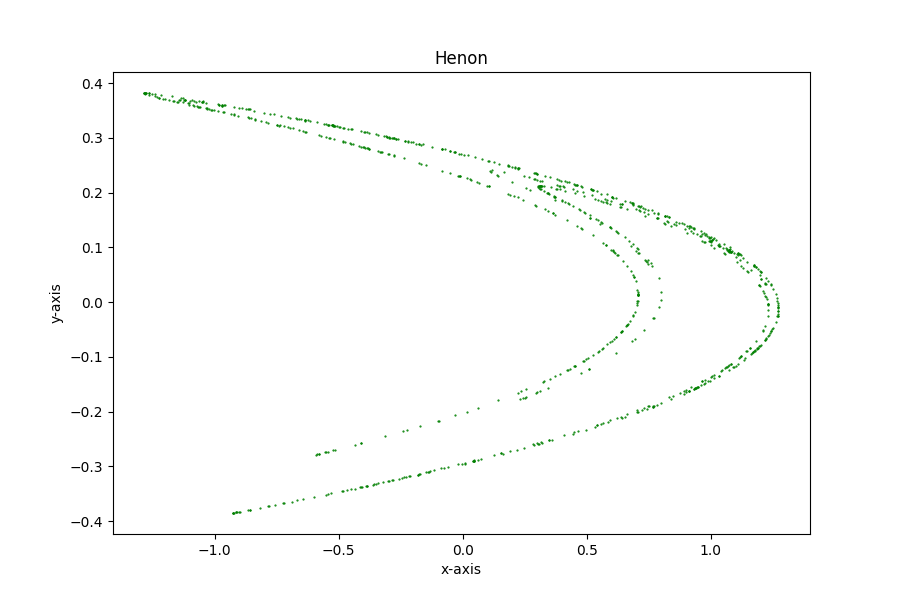

In [366]:
fig = plt.figure(figsize=(9, 6))
ax = plt.axes()
# creating the plot
ax.scatter(x, y, color='green', s = 0.3)
  
# setting title and labels
ax.set_title("Henon")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
# ax.set_zlabel('z-axis')
  
# displaying the plot
plt.show()

In [367]:
x = 0.5
y = 0
z = 0.1
cut = 80
model = Gaussian_map(x, y, z)
# chen.time_scale = 0.001
n = 1000
out = []
for i in range(n):
    a = model()
    # if i % 400 == 0:
    out.append(a)
out = np.array(out)
x, y, z = out[cut:n,0], out[cut:n, 1], out[cut:n, 2]

m = melody()
x_out, y_out,z_out = m(x,y,z)

a = xyz_midi()
a.music_duration = 40
a(x,y,z)
a.play()
# !timidity test.mid -Ow -o - | ffmpeg -i - -acodec libmp3lame -ab 64k Gaussian_map.mp3

[1.000e+00 2.000e+00 4.000e+00 8.000e+00 1.600e+01 3.200e+01 6.400e+01
 1.280e+02 2.560e+02 5.120e+02 1.024e+03 2.048e+03 4.096e+03]


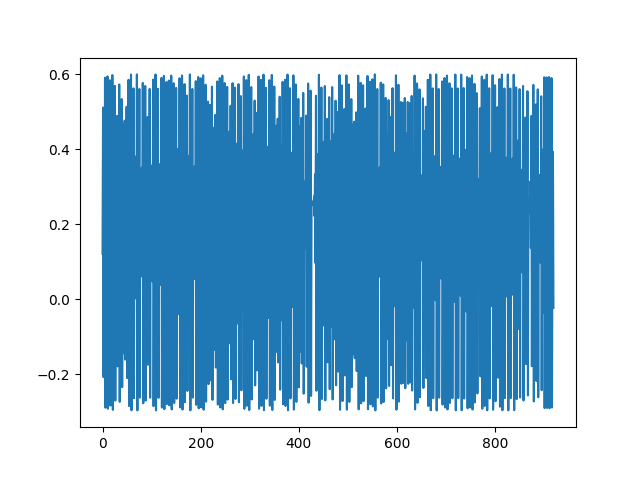

In [368]:
plt.close('all')
plt.plot(x)
plt.show()